# Homework 5 - Dimensionality Reduction and Clustering

We will now use some of our machine learning tools to read hand-drawn numbers and classify them.  This is useful for many reasons - banks create apps that allow clients to cash checks from home, and many other companies would like to read in handwritten numbers to convert physical files into digital copies.  The basic principles and ideas of classifying images can be applied to even more complex problems, such as AI-driven cars that need to analyze their situation and avoid crashes and other threats. For this reason, it is important to be able to classify these images as well as possible.

## Getting Started

We'll begin by setting up our notebook:

In [1]:
# Import useful tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import sklearn
import missingno as msno

# Set settings for notebook
sns.set(style = 'ticks', palette='Set2')
%matplotlib inline
plt.style.use('seaborn')
pd.set_option('display.max_columns', 50)

Now that we have our settings and package imported, we can import our dataset.  For this project, we will use the MNIST dataset, which consists of images of digits 0 through 9, all in image files that are 28 pixels by 28 pixels.  This isn't the clearest image, but we still have 784 individual pixels to use in our model. 

Each pixel has a shade somewhere between black and white.  In fact, there are 256 different values possible for these pixels (all integers from 0 through 255), with the higher numbers indicating darker shades.

We'll see how we can do - let's start by load in the data:

In [2]:
# Import data
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

Now that our data is loaded in, we'll take a look to ensure that everything works as it should.

In [3]:
print(X.shape, y.shape)

(70000, 784) (70000,)


So our data has 70,000 entries, with 784 variables - just as we expected. Now we'll take a look at a few of the entries just to see how each image looks.

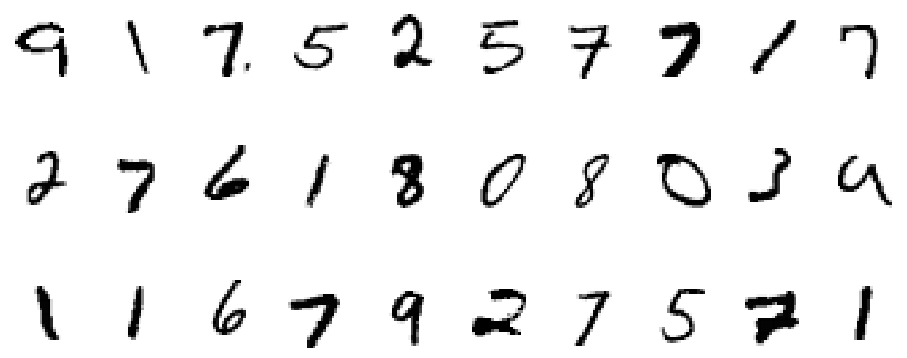

In [4]:
# Randomization of variable order - to pick a variety of entries, since they are currently ordered
rndm = np.random.permutation(X.shape[0])

# Dataframe for data
features = ['pixel' + str(i) for i in range(X.shape[1])]
dfX = pd.DataFrame(X, columns = features)

# Plot the graph
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1)
    ax.grid(False)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.matshow(dfX.loc[rndm[i]].values.reshape((28,28)).astype(float),
               cmap = 'Greys')
plt.show()

While the images aren't as clear as they could be, there's definitely enough to classify each number. This is the easiest way for us as humans to read and classify each number, but it's easier for the computer to read a "flattened" version of this data - that's why we'll feed it a vector of 784 variables, where each represents one of the pixels in each of the images as shown above.

## Classification

We'll step through this process as directed in the homework, but first, we need to import necessary packages and functions:

In [5]:
from sklearn.datasets import make_regression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score as hs
from sklearn.metrics import completeness_score as cs
from sklearn.metrics import adjusted_rand_score as ars
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler as SS

### 1.) PCA

PCA, or Principal Component Analysis, allows us to project our data onto the axes (or components) with the highest variance.  In other words, we focus on the variables that change the most between different types of data, as these provide the best indication of differences in the numbers. First, we'll find the principlal direction of greatest variance, and then find subsequent axes orthogonoal to it (and to each other, if there are more than 2 axes) to find the largest directions of variance.

SciKit Learn can perform singular value decomposition to find these principal components with the largest variance, and it will subtract the mean of each component to center everything at the origin.

In [6]:
print("Explained Variance Ratio, Per Principal Component, Decreasing Importance")
pca = PCA(n_components=2)
Xdim = pca.fit_transform(X)
print("2 Components:" + str(pca.explained_variance_ratio_))
pca = PCA(n_components=5)
Xdim = pca.fit_transform(X)
print("5 Components:" + str(pca.explained_variance_ratio_))
pca = PCA(n_components=10)
Xdim = pca.fit_transform(X)
print("10 Components:" + str(pca.explained_variance_ratio_))

Explained Variance Ratio, Per Principal Component, Decreasing Importance
2 Components:[ 0.09746116  0.07155445]
5 Components:[ 0.09746116  0.07155445  0.06149531  0.05403384  0.04888933]
10 Components:[ 0.09746116  0.07155445  0.06149531  0.05403385  0.04888934  0.04305227
  0.03278261  0.02889641  0.02758364  0.02342139]


We can see from the output that a few of the components actually have significant amounts of variance.  Even with just two variables (out of 784), we can explain about 16% of the variance (9.7% + 7.2%).  This clearly isn't enough to make any detailed classifications quite yet, but it's nice to know that PCA will help us at least somewhat.

##### a.) Determining the Optimal Number of Components

Below, we'll plot the explained variance as we increase the number of principal components in our analysis.

In [7]:
# PCA
pca = PCA(n_components=200)
Xpca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

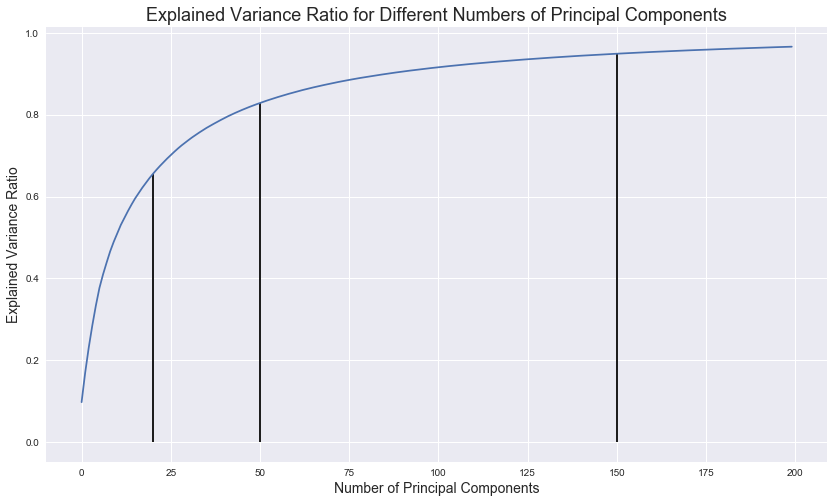

In [8]:
# Plot
f, ax = plt.subplots(figsize = (14,8))
ax.set_title("Explained Variance Ratio for Different Numbers of Principal Components", 
             fontsize = 18)
plt.ylabel("Explained Variance Ratio", fontsize = 14)
plt.xlabel("Number of Principal Components", fontsize = 14)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[20],x=20)
plt.vlines(ymin=0,ymax=cum_ratio[50],x=50)
plt.vlines(ymin=0,ymax=cum_ratio[150],x=150)
plt.show()

We can see that the explained variance ratio increases quite dramatically for the first 20 or 25 components that are included, and continues to rise much more slowly after that.  We'll see how well this works using 20, 50, and 150 components (these seem to correspond to points where the curve either "bends" or flattens out).  As can be seen below, these correspond to approximately 65%, 83%, and 95% of the explained variance ratio.  While perhaps none of these (expect 95%) stands out as a "nice" threshold to use, they all explain more than 50% of the variance and are reasonably well-spaced (with differences of 20% and 10% between the three cutoffs).

In [9]:
print("Explained Variance Ratio, Per Principal Component, Decreasing Importance")
print("20 Components: " + str(cum_ratio[20]))
print("50 Components: " + str(cum_ratio[50]))
print("150 Components: " + str(cum_ratio[150]))

Explained Variance Ratio, Per Principal Component, Decreasing Importance
20 Components: 0.655367189507
50 Components: 0.828587379107
150 Components: 0.948966223485


##### b.) Plotting Two Components

We'll plot the variance across two components below to see how the different numbers are "grouped" together when just using these components.

In [10]:
pca = PCA(n_components=2)
Xdim2 = pca.fit_transform(X)
dfXdim2 = pd.DataFrame(Xdim2, columns=['Principal Component 1', 'Principal Component 2'])
dfXdim2['Label'] = y

Below, we'll make two different plots.  The first will show how the prinicpal components attempt to separate the different groups of numbers - each color represents one number, and will be placed on the graph according to its two principal components.

The second graph just shows all of the points, making no distinction between colors.  By making the point size smaller and using just one color, we can now see more clearly that these two principal components are uncorrelated with each other - exactly as we want.  There also appears to be some small amount of grouping in this graph, which (as far as we can tell) correlates to specific number classes.

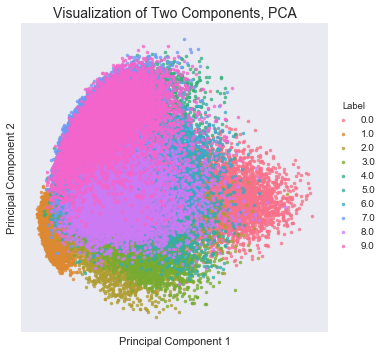

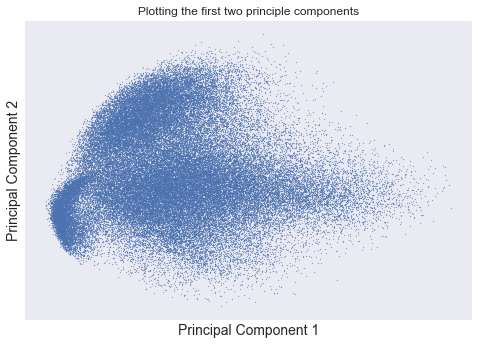

In [11]:
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=dfXdim2, 
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
plt.xticks([])
plt.yticks([])
ax.set_title("Visualization of Two Components, PCA", fontsize = 14)
plt.show()

plt.title("Plotting the first two principle components")
plt.xticks([])
plt.yticks([])
plt.ylabel("Principal Component 2", fontsize = 14)
plt.xlabel("Principal Component 1", fontsize = 14)
plt.scatter(dfXdim2['Principal Component 1'], dfXdim2['Principal Component 2'], alpha=.5, s=1)
plt.show()

This first plot shows that there is some element of separation between the numbers - all of the "9" group lies roughly in the upper left quarter of the graph, while it appears that the "1" group is below it, to the right.  Still, there is a large amount of overlap between these numbers, and it would be impossible to draw any curve or shape that would completely separate one number group from the rest.

The second graph shows a large spread in the values of this data, where the two components (as previously stated) are uncorrelated with each other.

We can see the amounts of variation in both directions in this data, and how images of different numbers tend to have similar values for their principal components.  We cannot actually tell what these principal components are, but we can see that, for at least some of the groups (like the orange "1" cluster), these two components actually do a passable job of attempting to cluster the data.

##### c.) Thoughts on PCA

PCA is useful for dimensionality reduction - it combines the many variables available in the first dataset into an arbitrary number of features, or the "principal components" as described above.  These components, or axes, preserve the most variance shown in the data, which allows a few variables to explain the most of the differences between separate data points.  Additionally, each principal component is orthogonal to the rest, meaning that the new features aren't superfluous (or a linear combination of the previously existing variables).

PCA is less useful in providing an explanation for the meaning of each principal component.  Since it finds the directions of greatest variance, it doesn't just find features that contribute significantly to the model (like Lasso or Ridge regressions would).  Interpretability decreases with the introduction of PCA.

Additionally, PCA has linear assumptions - it chooses vectors that are linear and orthogonal to each other.  However, the true data may have different "shapes" and vary in polynomial or logarithmic (or other) forms.  PCA will approximate these relationships and directions of variance linearly, but can only do so much.

##### d.) PCA for Compression

PCA is a useful tool in image compression. Let's take a look at how the images change with different numbers of principal components when we compress the data and then expand it.

First, let's look at one particular image before compression:

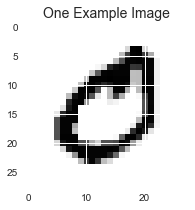

In [12]:
fig = plt.figure(figsize=(3,3))
plt.imshow(X[1].reshape((28,28)), cmap='Greys')
ax = plt.gca()
ax.set_title("One Example Image", fontsize = 14)
plt.show()

We'll use 3, 75, and 150 components, since these all provide significanly different explained variance ratios (and have lower dimensionality than the ones we used earlier).  After reducing the dimensionality, we'll use "inverse_transform" to get back to a 28x28 pixel image:

In [13]:
# 3 components
pca = PCA(n_components=3)
Xdim3 = pca.fit_transform(X)
Xdim3 = pca.inverse_transform(Xdim3)

# 75 components
pca = PCA(n_components=75)
Xdim75 = pca.fit_transform(X)
Xdim75 = pca.inverse_transform(Xdim75)

# 150 components
pca = PCA(n_components=150)
Xdim150 = pca.fit_transform(X)
Xdim150 = pca.inverse_transform(Xdim150)

We now have our 3 different matrices, with the compressed data. We'll plot these images again:

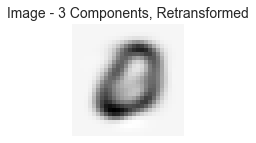

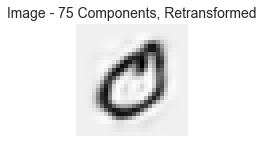

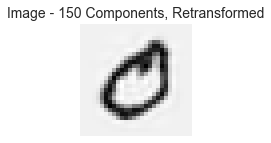

In [14]:
# 3 components
fig = plt.figure( figsize=(16,7) )
ax = fig.add_subplot(3,1,1)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.imshow(Xdim3[1].reshape((28,28)), cmap='Greys')
ax = plt.gca()
ax.set_title("Image - 3 Components, Retransformed", fontsize = 14)
plt.show()
    
# 75 components
fig = plt.figure( figsize=(16,7) )
ax = fig.add_subplot(3,1,2)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])    
plt.imshow(Xdim75[1].reshape((28,28)), cmap='Greys')
ax = plt.gca()
ax.set_title("Image - 75 Components, Retransformed", fontsize = 14)
plt.show()

# 150 components
fig = plt.figure( figsize=(16,7) )
ax = fig.add_subplot(3,1,3)
ax.grid(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.imshow(Xdim150[1].reshape((28,28)), cmap='Greys')
ax = plt.gca()
ax.set_title("Image - 150 Components, Retransformed", fontsize = 14)
plt.show()

Note that each image looks even clearer as the dimensionality increases.  Still, with relatively few components, we can read the number.  We'll plot the full image below again, just as a reminder:

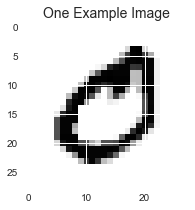

In [15]:
fig = plt.figure( figsize=(3,3))
plt.imshow(X[1].reshape((28,28)), cmap='Greys')
ax = plt.gca()
ax.set_title("One Example Image", fontsize = 14)
plt.show()

### 2.) t-SNE

This is another dimensionality-reduction technique that is often used for visualization. In reducing the dimensions (here, we'll reduce it to two dimensions), it uses a local and non-linear technique to provide clear separation.

Because of this, we'll introduce the hyperparameter "perplexity," which balances between local and global aspects of the data to give a rough estimate of the number of close neighbors each point should have.

##### a.) Plotting t-SNE in Two Dimensions

In [16]:
# Dimensionality-reduction, using 20 components (for speed and ease of computation)
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

# Randomly shuffle data and choose 10,000 observations to sample
rows = np.arange(70000)
np.random.shuffle(rows)
n_select = 10000

# TSNE with perplexity 5
tsne5 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne_results5 = tsne5.fit_transform(X_pca[rows[:n_select],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 2.870s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.820343
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.326958
[t-SNE] Error after 1000 iterations: 1.892630


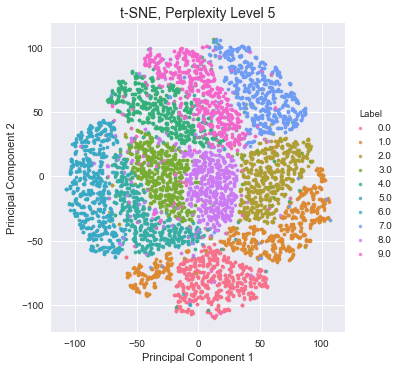

In [17]:
# Graphing the t-SNE plot
df_tsne5 = pd.DataFrame(tsne_results5, columns=['Principal Component 1', 
                                                'Principal Component 2'])
df_tsne5['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', 
           data=df_tsne5, hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("t-SNE, Perplexity Level 5", fontsize = 14)
plt.show()

We can already see that the plot is much, much clearer than it was for PCA - in fact, with relatively few exceptions, each group is nicely divided. 

##### b.) Changing Perplexity

So far, we've only tried one value for perplexity (5).  Since recommended values for perplexity are between 5 and 50, we'll see what our plot looks like with values of 25 and 50, too (we choose 25 because it's roughly in the middle of 5 and 50).

We'll continue to see what the graphs look like as perplexity increases:

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 3.987s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.279729
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.593773
[t-SNE] Error after 1000 iterations: 1.783392

[t-SNE] Computing 151 nearest ne

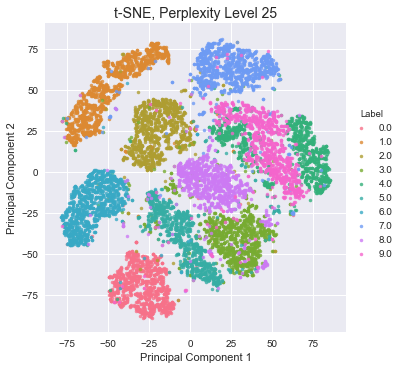

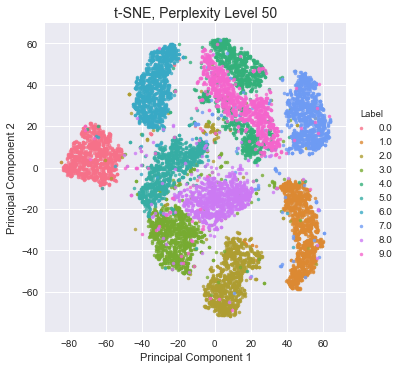

In [18]:
# Different perplexities
tsne25 = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=1000, learning_rate=200)
tsne_results25 = tsne25.fit_transform(X_pca[rows[:n_select],:])
print("")
tsne50 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne_results50 = tsne50.fit_transform(X_pca[rows[:n_select],:])

# Graphing both plots
df_tsne25 = pd.DataFrame(tsne_results25, columns=['Principal Component 1', 
                                                  'Principal Component 2'])
df_tsne25['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsne25,
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("t-SNE, Perplexity Level 25", fontsize = 14)
plt.show()

df_tsne50 = pd.DataFrame(tsne_results50, columns=['Principal Component 1', 
                                                  'Principal Component 2'])
df_tsne50['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', 
           data=df_tsne50, hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("t-SNE, Perplexity Level 50", fontsize = 14)
plt.show()

We can now see that the t-SNE plots become more condensed visually as perplexity increases. Additionally, the location of the groups can shift with different values for perplexity - this isn't a surprise, since this parameter just looks at similarity between groups, and our principal components are not scaled linearly.

The groups seem to stay fairly close together with changes in perplexity, although increases in perplexity apparently increase the confusion between "9" and "4" - the green "4" group is divided into two sections by the pink "9" group as perplexity goes from 5 to 25 and stays that way when perplexity is set at 50.

##### c.) Changing Learning Rates and Iterations

We've tried a few different perplexities, but now we'll see how things look as we adjust the learning rate and the number of iterations in the model. Since a perplexity level of 50 seems to provide the greatest visual separation (excluding the problems mentioned before), we'll stick with setting perplexity at 50.

###### i.) Learning Rates
First, we'll try two other learning rates - we've already tried 200, so we'll try 100 and 1000 (keeping all else constant, and trying one higher and one lower).

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.012s...
[t-SNE] Computed neighbors for 10000 samples in 4.691s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.496595
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.123405
[t-SNE] Error after 1000 iterations: 1.674720

[t-SNE] Computing 151 nearest n

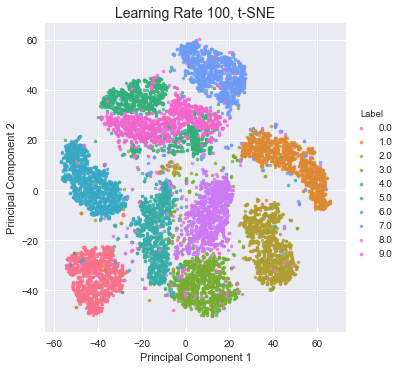

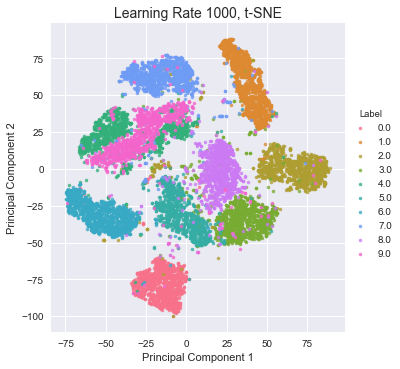

In [19]:
# Different learning rates
tsnel100 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, 
                learning_rate=100)
tsne_resultsl100 = tsnel100.fit_transform(X_pca[rows[:n_select],:])
print("")
tsnel1000 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, 
                 learning_rate=1000)
tsne_resultsl1000 = tsnel1000.fit_transform(X_pca[rows[:n_select],:])

# Graphing both plots
df_tsnel10 = pd.DataFrame(tsne_resultsl100, columns=['Principal Component 1', 
                                                     'Principal Component 2'])
df_tsnel10['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsnel10, 
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("Learning Rate 100, t-SNE", fontsize = 14)
plt.show()

df_tsnel1000 = pd.DataFrame(tsne_resultsl1000, columns=['Principal Component 1', 
                                                        'Principal Component 2'])
df_tsnel1000['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsnel1000,
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("Learning Rate 1000, t-SNE", fontsize = 14)
plt.show()

Note that the graphs are quite similar (ignoring the rotations and reflections of the figures). The shapes are all similar to each other, and increasing or decreasing the learning rate ends up in similar grouping with similar amounts of discoloration (different color dots that have "infiltrated" other groups).

From these graphs, we draw the conclusion that t-SNE results are robust to at least some changes in the learning rate.

##### ii.) Iterations

Now we'll try a few different settings for iterations - since we've already looked at the case with 1000 iterations, we'll also examine 250 and 2000 iterations (again, one higher and one lower).  We'll keep the perplexity at 50 and set the learning rate back to 200 to compare it to the original results.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 6.570s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.496595
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.110664
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070

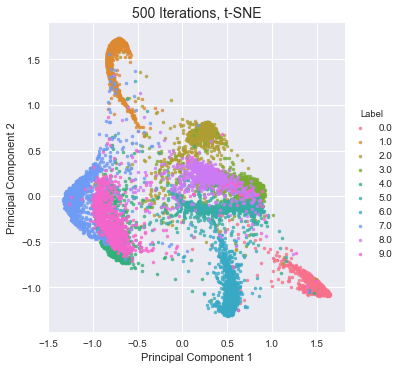

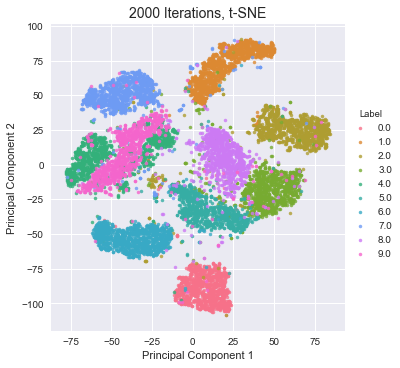

In [20]:
# Different iteration counts
tsne50i = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=250, learning_rate=200)
tsne_results50i = tsne50i.fit_transform(X_pca[rows[:n_select],:])
print("")
tsne50ii = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=2000, learning_rate=200)
tsne_results50ii = tsne50ii.fit_transform(X_pca[rows[:n_select],:])

# Graphing both plots
df_tsne50i = pd.DataFrame(tsne_results50i, columns=['Principal Component 1', 
                                                    'Principal Component 2'])
df_tsne50i['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsne50i, 
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("500 Iterations, t-SNE", fontsize = 14)
plt.show()

df_tsne50ii = pd.DataFrame(tsne_results50ii, columns=['Principal Component 1', 
                                                      'Principal Component 2'])
df_tsne50ii['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsne50ii, 
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("2000 Iterations, t-SNE", fontsize = 14)
plt.show()

We can see that for low learning rates, the plot looks quite different.  However, the graphs for 1000 and 2000 iterations look quite similar, it is robust to varying iteration counts for some larger range.

### 3.) K-Means Clustering

We'll now transition to unsupervised learning with k-means clustering. This algorithm will find groups of observations that are similar within their group but as distinct as possible outside of the group.

##### a.) Choosing K

The hyperameter in question here is "k" - the number of clusters we'll want to find. We'll choose to set k = 10, since we're trying to classify any given image as a number from 0 to 9.

K-Means Clustering can also be used when no ground truth is assumed to exist - in this case, we could use the "elbow" method, as in the PCA section above, to find some bend in the "sum of squared distances" curve and choose the k associated with it.

In [21]:
# Subsample of the data
X_full = pd.DataFrame(X)
Xsub = X_full.sample(n = 10000)

# Fit model
kmeans = KMeans(n_clusters=10)
kmeans.fit(Xsub)

# Predict on full data
sk_clusters = kmeans.predict(X_full)

##### b.) Evaluating Clustering

It is necessary to evaluate the clustering we have performed, to see if this is a viable method to classify each image.  In some cases, k-means is used for classification where no ground truth is assumed, but that is not the case for this - each image is known to be an integer from 0 to 9.  Because of this, we can use an evaluation method that compares the result against the truth.

First, we use the Adjusted Rand Index, which compares the values in "true labels" to those in "predicted labels".  This is useful because assignments are close to 0 when they are random, and bounded between -1 and 1.

In [22]:
ars(y, sk_clusters)

0.35667351949736281

Two other ways of measuring the effectiveness of our clustering seem to be particularly useful in this case - homogeneity and completeness.  Homogeneity measures whether each cluster contains only members of one class, and completeness measures whether all members of one class are assigned to the same cluster.  These seem to be more intuitive, so we'll look at both, as well.  Both metrics are bounded between 0 and 1, with higher scores meaning better performance.

In [23]:
hs(y, sk_clusters)

0.47949105026712041

In [24]:
cs(y, sk_clusters)

0.48322153630950659

##### c.) Visualization of Clusters (t-SNE)

We'll see how our k-means clustering looks when we use t-SNE to visualize it.

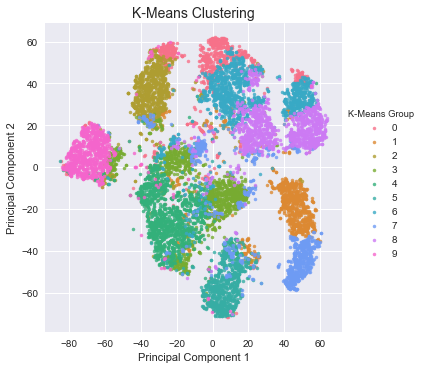

In [25]:
# K-Means Clustering
df_tsne50 = pd.DataFrame(tsne_results50, columns=['Principal Component 1', 
                                                  'Principal Component 2'])
df_tsne50['K-Means Group'] = sk_clusters[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsne50, 
           hue='K-Means Group', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("K-Means Clustering", fontsize=14)
plt.show()

We have our data here, in the "t-SNE plot" and with one color for each cluster.  Note that the color does not correspond to the colors used above for specific numbers (that is, orange points in this graph just belong to one cluster, and the model is not saying that these are all the number 1).  This just shows how the different clusters fall on a plot with the two principal components.

Below, we'll look again at the "True Clustering," or how the color scheme would look if we just colored each point according to what we already know to be true.  This is just for comparison:

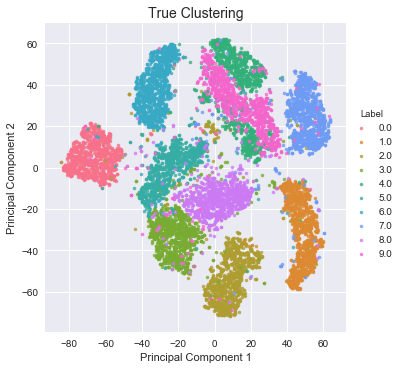

In [26]:
# True Clustering
df_tsne50 = pd.DataFrame(tsne_results50, columns=['Principal Component 1', 
                                                  'Principal Component 2'])
df_tsne50['Label'] = y[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsne50, 
           hue='Label', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("True Clustering", fontsize = 14)
plt.show()

We can see that k-means clustering does a good job of finding some of the groupings, but in an unsupervised setting like this, it sometimes divides groups that should be of the same color (like the orange "1" group in the second graph, which is divided into two by k-means clustering).

##### d.) Scaling Data

Each of these features is a pixel, with comparable values. We should not need to scale the data, as it has already been divided by 255 at the beginning, and each pixel's value has equivalent meaning.

Nevertheless, we'll take a look at the results when we scale the data:

In [27]:
# Scaling data with standard scaler
ss = SS()
sX = ss.fit_transform(X_full)
sXsub =ss.fit_transform(Xsub)

# Fit model
kmeans = KMeans(n_clusters=10)
kmeans.fit(sXsub)
sk_clusters = kmeans.predict(sX)

Now we'll see how the k-means clustering performs on the scaled data

In [28]:
print("Adjusted Rand Index: " + str(ars(y, sk_clusters)))
print("Homogeneity Score: " + str(hs(y, sk_clusters)))
print("Completeness: " + str(cs(y, sk_clusters)))

Adjusted Rand Index: 0.317092939532
Homogeneity Score: 0.422572794346
Completeness: 0.442831977655


These scores are slightly lower than before for every index.

##### e.) Robustness

We'll now see if this same model predicts as well on a different subsample of the data - we'll take another subsample at random, use the first model (that we've already trained), and see how the new graph looks:

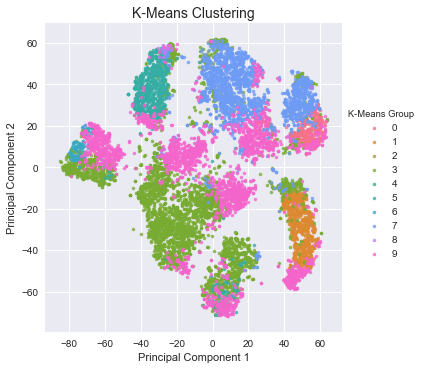

Adjusted Rand Index: 0.173229759556
Homogeneity Score: 0.308367832549
Completeness: 0.432423440941


In [29]:
# New subsample
X_full = pd.DataFrame(X)
Xsub = X_full.sample(n = 10000)

# Predict on new subsample with old model
sk_clusters = kmeans.predict(X_full)

# Graph clustering
df_tsne50 = pd.DataFrame(tsne_results50, columns=['Principal Component 1', 
                                                  'Principal Component 2'])
df_tsne50['K-Means Group'] = sk_clusters[rows[:n_select]]
sns.lmplot(x='Principal Component 1', y='Principal Component 2', data=df_tsne50, 
           hue='K-Means Group', fit_reg=False, markers = ".")
ax = plt.gca()
ax.set_title("K-Means Clustering", fontsize=14)
plt.show()

# Model scores
print("Adjusted Rand Index: " + str(ars(y, sk_clusters)))
print("Homogeneity Score: " + str(hs(y, sk_clusters)))
print("Completeness: " + str(cs(y, sk_clusters)))

This model doesn't perform quite as well on a separate subsample - note that the clustering on the chart looks different, and each score is lower.

### 4.) Hierarchical Clustering

Finally, we'll take a look at hierarchical clustering.  In this method, we'll allow our model to decide how many clusters to form by using bottom-up clustering.  This means that the model will find relationships between the observations for us by finding the closest observations and working "up" toward others to find similar clusters.

We'll also just examine a subset of the data - we'll take a random sample to speed up the computation time.

In [30]:
#X_full = pd.concat([dfX, pd.DataFrame(y, columns = ['Label'])], axis = 1)
X_full = pd.DataFrame(X)
Xsub = X_full.sample(n = 2500)

Here, we'll use the "complete" linkage method, which uses the "Farthest Point Algorithm" to determine distance - the distance between two clusters is the largest distance between two points of different clusters.

In [31]:
Z = linkage(Xsub, 'complete')

##### a.) Plotting

Now we'll plot the dendrogram below:

Text(0.5,1,'Complete Linkage Dendrogram')

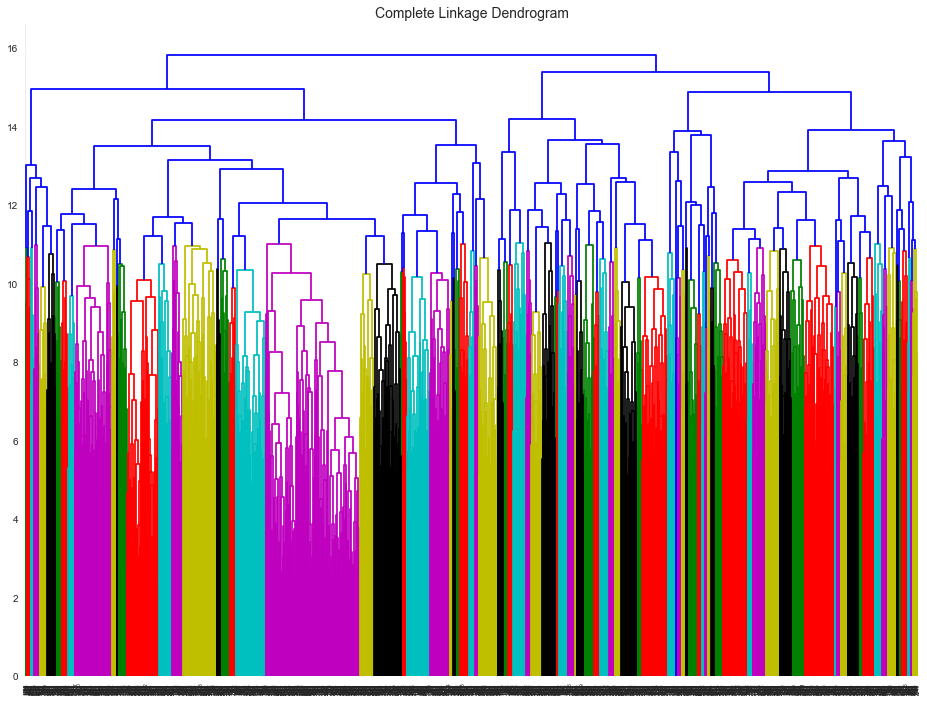

In [32]:
plt.figure(figsize=(16, 12))
dn_c = dendrogram(Z)
plt.title("Complete Linkage Dendrogram", fontsize=14)

Now we'll use the "single" linkage method, which uses the "Nearest Point Algorithm" to compute distance (the smallest distance between points of the different clusters).

Text(0.5,1,'Single Linkage Dendrogram')

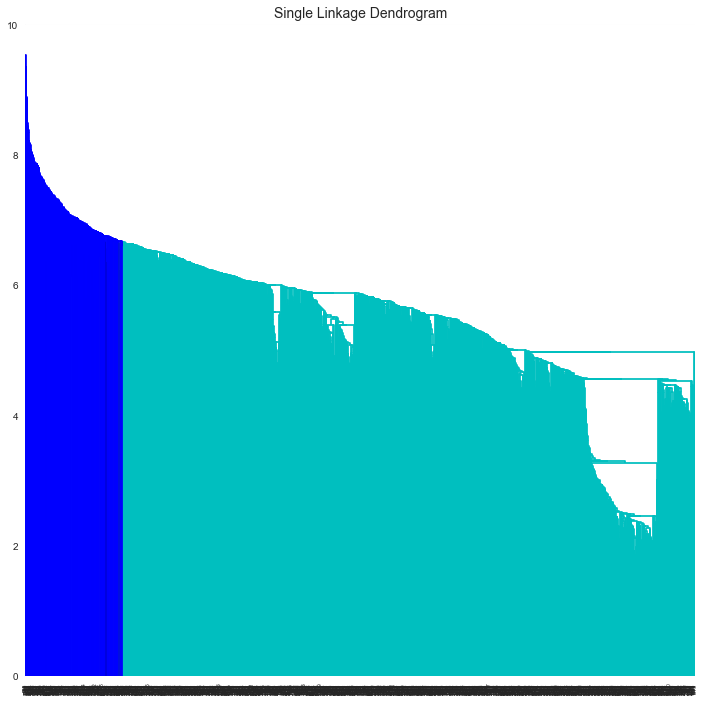

In [33]:
Z = linkage(Xsub, 'single')
plt.figure(figsize=(12, 12))
dn_s = dendrogram(Z)
plt.title("Single Linkage Dendrogram", fontsize=14)

Finally, we'll try the "average" linkage method, which takes the average distance between each point in one group with each point in another, and divides it by the product of the cardinalities of the clusters.

Text(0.5,1,'Average Linkage Dendrogram')

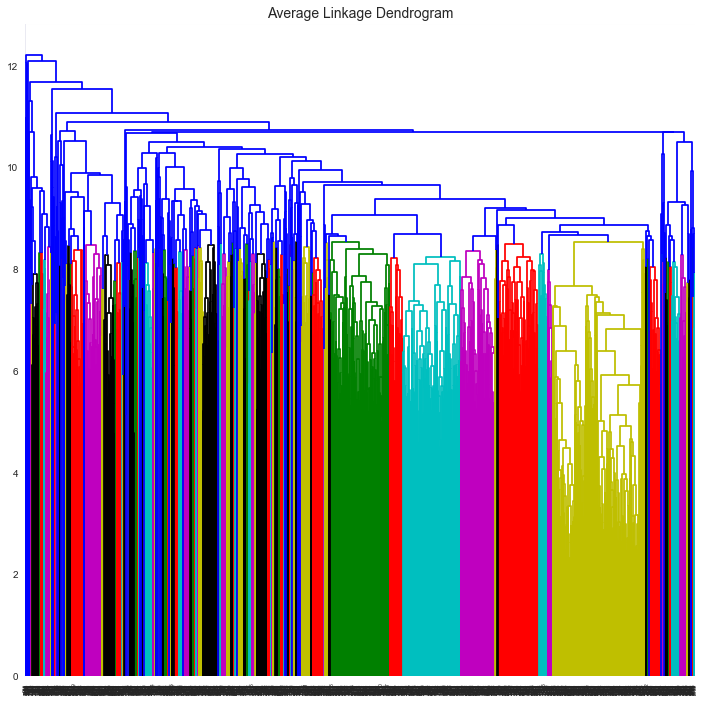

In [34]:
Z = linkage(Xsub, 'average')
plt.figure(figsize=(12, 12))
dn_a = dendrogram(Z)
plt.title("Average Linkage Dendrogram", fontsize=14)

Note that each linkage method provides radically different results.  The "average" and "complete" methods provide trees with many different colors of branches, and have a similar shape.  On the other hand, the "single" method of linkage results in two very large groups, along with a few other very small groups.

We'll try one last method - "ward", which minimizes the variance between clusters:

Text(0.5,1,'Ward Linkage Dendrogram')

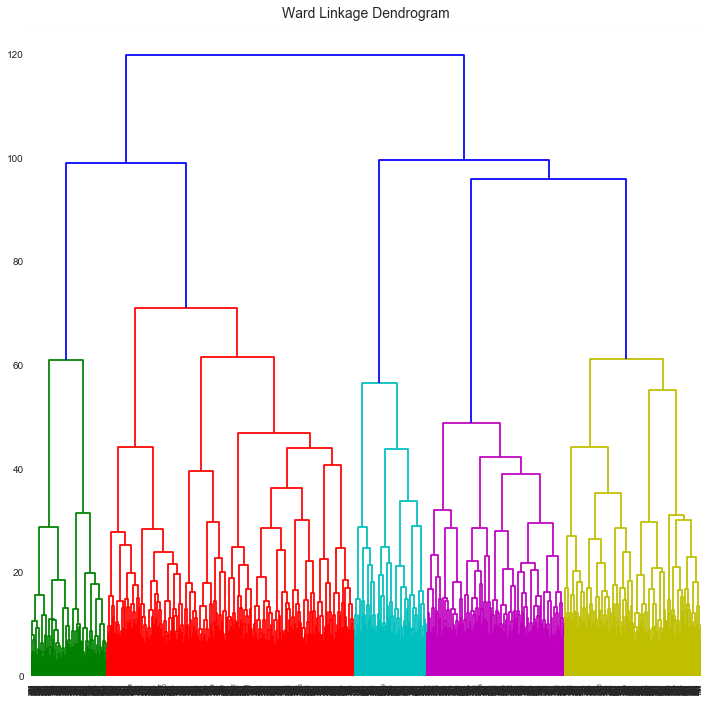

In [35]:
Z = linkage(Xsub, 'ward')
plt.figure(figsize=(12, 12))
dn_a = dendrogram(Z)
plt.title("Ward Linkage Dendrogram", fontsize=14)

This looks a lot nicer - it still doesn't give us 10 clusters (which is what we'd prefer, given our data), but it seems to make more sense visually than some of the other dendrograms that we've looked at.

##### b.) Clusters

Based off of the last graph, 5 clusters seem reasonable.  The other graphs give larger numbers of groups than we would like (due to the linkage method), or, in the case of single linkage, puts almost all of the data into two very large groups.  Also, for these other graphs, the number of clusters suggested by the dendrograms increases with the number of images included in the sample (computing time also increases dramatically with larger samples).

##### c.) Linkage Methods

We've plotted a few linkage methods above already - the dendrogram changes dramatically with each linkage method, although the "complete" and "average" methods seem to do something roughly similar.  The number of the clusters suggested by the data depends significantly with the linkage method used.

### Conclusions



We can see a lot of different results with different methods.  The latter two, k-means clustering and hierarchical clustering, are unsupervised methods that are good at separating the data, but not necessarily good at sorting it into predetermined classes (as can be seen especially with a few of the dendrograms with different linkage methods).  PCA is able to preserve a surprising amount of data even when compressing into a few components (as we saw when compressing, decompressing, and visualizing images).  We were able to get fairly well-defined groups when using t-SNE, as well, and saw a few interesting effects when changing those hyperparameters.

Overally, dimensionality reduction and clustering are powerful tools, but need to be used carefully in order to use the data as desired.